# Fuse Threshold Networks

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy as sp
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve, cg
import numpy.random
import generate_adjacency_matrix as gen_adj
import resistor_networks_basic as rnets
from matplotlib.patches import ConnectionPatch

import itertools

from __future__ import division

In [3]:
import matplotlib.pyplot as plt

In [4]:
class FuseThresholdNetwork(rnets.ResistorNetwork):
    """
    This class inherits from ResistorNetwork with the aim of adding some dynamical behavior to the
    resistors.  In particular, when a resistor has past a certain current threshold, the conductance
    is switched from G_OFF to G_ON. To initialize, we require:
    
        G                     - An NxN sparse CSR matrix containing the conductances in the network of N nodes
        external_voltages     - An Nx1 dense vector of external voltages.  Nodes not set to an external voltages
                                contain a Nan. The shape (N,) is preferred
        I_threshold           - A sparse array of thresholds for each memristor
        G_OFF                 - The conductance in the low conductivity OFF state.  Generally set to 1.
        G_ON                  - The conductance in the high conductivity ON state.  Set to 100 by default.
    
    Other available attributes after initialization are:
        currents              - An NxN sparse matrix of currents in the network.  As many tasks in the network will
                                require that the currents be calculated, it is best that we do this once and share.
        rows_G
        cols_G
    """
    
    def __init__(self, G, external_voltages, I_threshold, G_OFF=1, G_ON=100):
        rnets.ResistorNetwork.__init__(self, G, external_voltages)
        self.I_threshold = I_threshold
        self.G_OFF = G_OFF
        self.G_ON = G_ON
        self.rows_G, self.cols_G = sparse.triu(self.G).nonzero()
        self.currents = None
            
    def calculate_currents(self):
        """
        calculates a matrix of currents running through each memristor.  Only the upper triangular portion
        of the matrix is calculated.
        """
        self.currents = sparse.lil_matrix(self.G.shape, dtype=float)
        self.currents[self.rows_G, self.cols_G] = np.multiply(self.G[self.rows_G, self.cols_G],
                                                  np.abs(self.voltages[self.rows_G] - self.voltages[self.cols_G]))
        self.currents = self.currents + self.currents.T
    
    def next_switching_factor(self):
        """
        Find the factor necessary to adjust the voltage to switch the next memristor
        """
        rows, cols = sparse.triu(self.G == self.G_OFF).nonzero()
        return np.min(np.divide(self.I_threshold[rows, cols], self.currents[rows, cols]))
        
    def switch_memristors(self):
        """
        Check the currents on each memristor.  Those that are in the low conductance state and that have a current
        above I_thresh will have their conductance switched to G_ON
        """
        switching_memristors = (self.currents > self.I_threshold).multiply(self.G == self.G_OFF).astype('bool')
        self.G[switching_memristors] = self.G_ON
        return switching_memristors.nnz / 2

    def switching_step(self):
        counter = []
        self.solve_voltages('spsolve')
        self.calculate_currents()
        num_switched = self.switch_memristors()
        while num_switched != 0:
            counter.append(num_switched)
            self.solve_voltages('spsolve')
            self.calculate_currents()
            num_switched = self.switch_memristors()
        return counter
    
    def new_voltage(self, prev_voltage):
        return prev_voltage * (self.next_switching_factor() + 1e-10)

    def update_voltage_busbar(self, voltage):
        """
        Using bus bar topology, this takes the previous voltage at the zeroth node and updates it so that the next memristor
        will flip
        """
        self.external_voltages[0:int(np.sqrt(self.G.shape[0]))] = voltage
        
    def display_diag_grid(self, ax, lattice_shape, display_variable, nodesize=5, bondwidth=3, colormin=None, colormax=None,
                     colormap_name=None):
        
        def node2xy(node_idx):
            """
            returns the x and y coordinates of a node index in our grid supposing that the 0,0 point is in the upper left
            and the positive y-axis points down
            """
            col_index = node_idx % lattice_shape[1]
            row_index = node_idx // lattice_shape[1]
            row_parity = row_index % 2
            
            return col_index + (0.5 * row_parity), 0.5 * row_index
        
        
        # Pull nonzero values to plot bonds
        rows, cols = sparse.triu(self.G).nonzero()
        
        
        # Set up colormap normalization
        
        if colormin != None:
            norm = plt.Normalize(vmin=colormin, vmax=colormax)
        elif display_variable == 'voltage':
            norm = plt.Normalize()
            norm.autoscale(self.voltages)
        elif display_variable == 'power':
            power = self.power()
            norm = plt.Normalize(vmin=power.min(), vmax=power.max())
        elif display_variable == 'conductance':
            # I'd like the OFF grey to be lighter than the minimum of the color map
            # so I'm setting it so that it falls 1/3 through the colormap
            mincond = min(self.G_OFF, self.G_ON)
            maxcond = max(self.G_OFF, self.G_ON)
            if self.G_ON > self.G_OFF:
                low_colormap = maxcond - 1.5 * (maxcond-mincond)
                norm = plt.Normalize(vmin=low_colormap, vmax=maxcond)
            else:
                high_colormap = mincond + 1.5 * (maxcond - mincond)
                norm = plt.Normalize(vmin=mincond, vmax=high_colormap)
        elif display_variable == 'voltage_drop':
            voltage_drop = self.voltage_drop_abs()
            norm = plt.Normalize(vmin=0, vmax=voltage_drop.max())
        elif display_variable == 'log_voltage_drop':
            voltage_drop = self.voltage_drop_abs()
            norm = plt.Normalize(vmin=np.log(voltage_drop.data.min()),
                                 vmax=np.log(voltage_drop.max()))
        
        if colormap_name != None:
            colormap = plt.get_cmap(colormap_name)
        else:
            if display_variable == 'voltage':
                colormap = plt.get_cmap('Reds')
            elif display_variable == 'power':
                colormap = plt.get_cmap('YlOrRd')
            elif display_variable == 'conductance':
                if self.G_ON > self.G_OFF:
                    colormap = plt.get_cmap('RdGy_r')
                else:
                    colormap = plt.get_cmap('RdGy')
            elif display_variable == 'voltage_drop':
                colormap = plt.get_cmap('jet')
            elif display_variable == 'log_voltage_drop':
                colormap = plt.get_cmap('jet')
        
        # Draw the bonds between nodes
        for node_i, node_j in itertools.izip(rows, cols):
            x_i, y_i = node2xy(node_i)
            x_j, y_j = node2xy(node_j)
            #Check for our wrap around nodes
            if node_j - node_i == 2*lattice_shape[1] - 1:
                x_i = x_i + lattice_shape[1]
            elif node_j - node_i == 1:
                x_j = x_j + lattice_shape[1]
            
            if display_variable == 'voltage':
                ax.plot([x_i, x_j], [y_i, y_j], 'k', lw = bondwidth)
            elif display_variable == 'power':
                ax.plot([x_i, x_j], [y_i, y_j], color=colormap(norm(power[node_i, node_j])), lw=bondwidth)
            elif display_variable == 'conductance':
                ax.plot([x_i, x_j], [y_i, y_j], color=colormap(norm(self.G[node_i, node_j])), lw=bondwidth)
            elif display_variable == 'voltage_drop':
                ax.plot([x_i, x_j], [y_i, y_j], color=colormap(norm(voltage_drop[node_i, node_j])), lw=bondwidth)
            elif display_variable == 'log_voltage_drop':
                ax.plot([x_i, x_j], [y_i, y_j], color=colormap(norm(np.log(voltage_drop[node_i, node_j]))), lw=bondwidth)
                
        # Now draw the nodes
        if display_variable == 'voltage':
            for node, volt in enumerate(self.voltages):
                x, y = node2xy(node)
                ax.plot(x, y, 's', markersize=nodesize, color=colormap(norm(volt)))
        elif display_variable == 'power' or 'conductance' or 'voltage_drop' or 'log_voltage_drop':
            for node in range(self.nodes):
                x, y = node2xy(node)
                ax.plot(x, y, 'ws', markersize=nodesize)
        
        # And finally set the axes to be just outside the grid spacing and invert the y_axis
        ax.set_xlim( -1, lattice_shape[1]+1)
        ax.set_ylim( -1, 0.5 * (lattice_shape[0]+1))
        ax.invert_yaxis()
        ax.xaxis.set_tick_params(labelbottom='off', labeltop='on')

### ON=100, Uniform [0,1)

In [5]:
L_x = 45
L_y = 2 * L_x + 1
g_ON = 100
g_OFF = 1

G = gen_adj.cubic_2d_diagonal_periodic((L_y,L_x))

r, c = sparse.triu(G).nonzero()
I_threshold = sparse.lil_matrix(G.shape, dtype='float')
I_threshold[r, c] = np.random.uniform(low=0, high=1, size=r.size)
I_threshold = I_threshold + I_threshold.T

V_initial = I_threshold.data.min() * (L_y-1) / 1 + 1e-10

external_voltages = np.empty((L_x*L_y,))* np.nan
external_voltages[0:L_x] = V_initial
external_voltages[-L_x:] = 0

test = FuseThresholdNetwork(G, external_voltages, I_threshold=I_threshold, G_OFF=g_OFF, G_ON=g_ON)

test.solve_voltages('spsolve')
test.calculate_currents()

counter = 0
total_memristors = 2 * L_x * (L_y-1)


event_list = []
voltages = [test.external_voltages[0]]
conductivities = [test.conductivity()]

event_list.append(test.switching_step())
counter += sum(event_list[-1])
conductivities.append(test.conductivity())

while counter < total_memristors:
    test.update_voltage_busbar(test.new_voltage(test.external_voltages[0]))
    voltages.append(test.external_voltages[0])
    event_list.append(test.switching_step())
    counter += sum(event_list[-1])
    conductivities.append(test.conductivity())

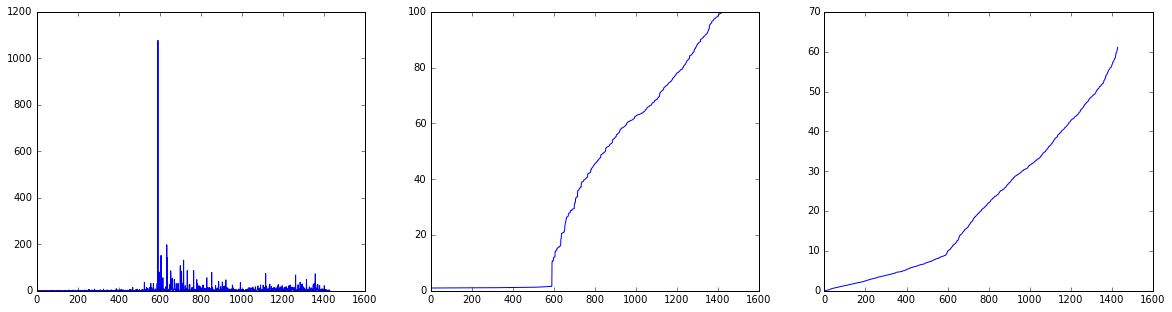

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].plot([sum(i) for i in event_list ])
ax[1].plot(conductivities)
ax[2].plot(voltages)

<Container object of 1406 artists>

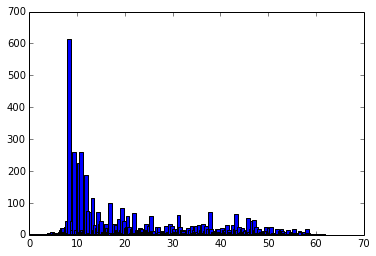

In [20]:
fig, ax = plt.subplots()

ax.bar(voltages, [sum(i) for i in event_list])

In [21]:
cond_4plot = []
volt_4plot = []
for n, v in enumerate(voltages):
    volt_4plot.extend([v, v])
    cond_4plot.extend([conductivities[n], conductivities[n+1]])
    



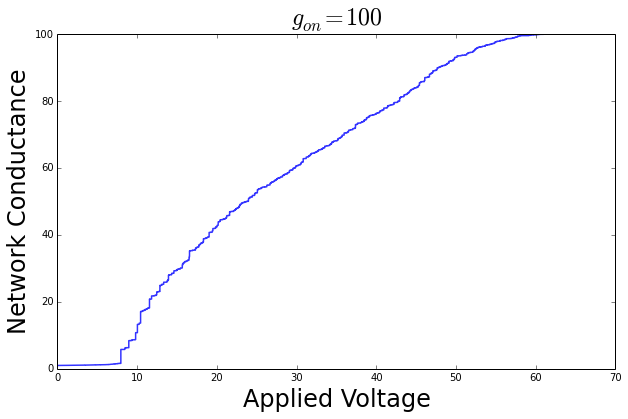

In [22]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(volt_4plot, cond_4plot, lw=1.5, alpha=0.8)
ax.set_xlim(0, 70 )
#ax.set_ylim(0, 80)

ax.set_title(r'$g_{on}=100$', fontsize=24, y=1.01)
ax.set_xlabel('Applied Voltage', fontsize=24)
ax.set_ylabel('Network Conductance', fontsize=24)

fig.savefig('Advancement_presentation/2DL45ON100_cond.png')

### ON=100000 Uniform [0, 1)

In [34]:
L_x = 32
L_y = 2 * L_x + 1
g_ON = 100000
g_OFF = 1

G = gen_adj.cubic_2d_diagonal_periodic((L_y,L_x))

r, c = sparse.triu(G).nonzero()
I_threshold = sparse.lil_matrix(G.shape, dtype='float')
I_threshold[r, c] = np.random.uniform(low=0, high=1, size=r.size)
I_threshold = I_threshold + I_threshold.T

V_initial = I_threshold.data.min() * (L_y-1) / 1 + 1e-10

external_voltages = np.empty((L_x*L_y,))* np.nan
external_voltages[0:L_x] = V_initial
external_voltages[-L_x:] = 0

test = FuseThresholdNetwork(G, external_voltages, I_threshold, G_OFF=g_OFF, G_ON=g_ON)

test.solve_voltages('spsolve')
test.calculate_currents()

counter = 0
total_memristors = 2 * L_x * (L_y-1)


event_list = []
voltages = [test.external_voltages[0]]
conductivities = [test.conductivity()]

event_list.append(test.switching_step())
counter += sum(event_list[-1])
conductivities.append(test.conductivity())

while counter < total_memristors:
    test.update_voltage_busbar(test.new_voltage(test.external_voltages[0]))
    voltages.append(test.external_voltages[0])
    event_list.append(test.switching_step())
    counter += sum(event_list[-1])
    conductivities.append(test.conductivity())

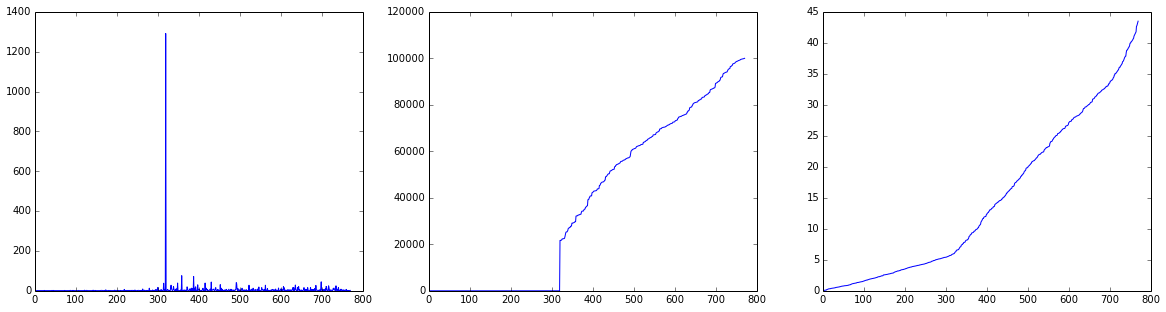

In [35]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].plot([sum(i) for i in event_list ])
ax[1].plot(conductivities)
ax[2].plot(voltages)

### ON=100 Exponential

In [36]:
L_x = 32
L_y = 2 * L_x + 1
g_ON = 100
g_OFF = 1

G = gen_adj.cubic_2d_diagonal_periodic((L_y,L_x))

r, c = sparse.triu(G).nonzero()
I_threshold = sparse.lil_matrix(G.shape, dtype='float')
I_threshold[r, c] = np.random.exponential(size=r.size)
I_threshold = I_threshold + I_threshold.T

V_initial = I_threshold.data.min() * (L_y-1) / 1 + 1e-10

external_voltages = np.empty((L_x*L_y,))* np.nan
external_voltages[0:L_x] = V_initial
external_voltages[-L_x:] = 0

test = FuseThresholdNetwork(G, external_voltages, I_threshold, G_OFF=g_OFF, G_ON=g_ON)

test.solve_voltages('spsolve')
test.calculate_currents()

counter = 0
total_memristors = 2 * L_x * (L_y-1)


event_list = []
voltages = [test.external_voltages[0]]
conductivities = [test.conductivity()]

event_list.append(test.switching_step())
counter += sum(event_list[-1])
conductivities.append(test.conductivity())

while counter < total_memristors:
    test.update_voltage_busbar(test.new_voltage(test.external_voltages[0]))
    voltages.append(test.external_voltages[0])
    event_list.append(test.switching_step())
    counter += sum(event_list[-1])
    conductivities.append(test.conductivity())

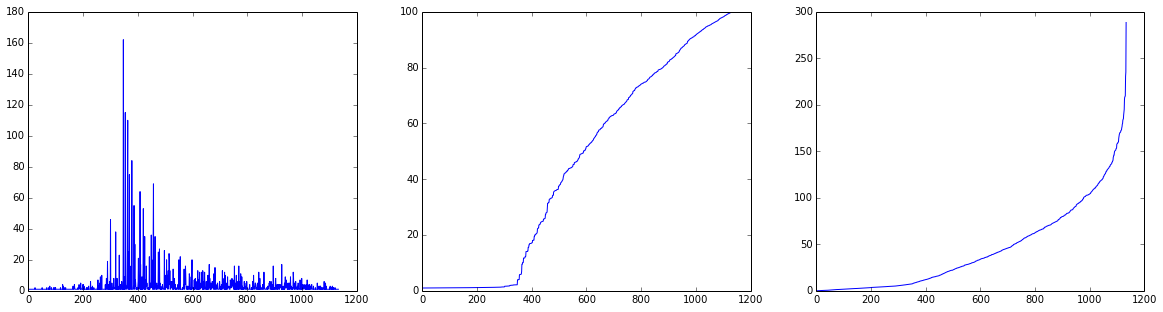

In [37]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].plot([sum(i) for i in event_list ])
ax[1].plot(conductivities)
ax[2].plot(voltages)

### ON=100, Uniform [0,100)

In [38]:
L_x = 32
L_y = 2 * L_x + 1
g_ON = 100
g_OFF = 1

G = gen_adj.cubic_2d_diagonal_periodic((L_y,L_x))

r, c = sparse.triu(G).nonzero()
I_threshold = sparse.lil_matrix(G.shape, dtype='float')
I_threshold[r, c] = np.random.uniform(low=0, high=100, size=r.size)
I_threshold = I_threshold + I_threshold.T

V_initial = I_threshold.data.min() * (L_y-1) / 1 + 1e-10

external_voltages = np.empty((L_x*L_y,))* np.nan
external_voltages[0:L_x] = V_initial
external_voltages[-L_x:] = 0

test = FuseThresholdNetwork(G, external_voltages, I_threshold, G_OFF=g_OFF, G_ON=g_ON)

test.solve_voltages('spsolve')
test.calculate_currents()

counter = 0
total_memristors = 2 * L_x * (L_y-1)


event_list = []
voltages = [test.external_voltages[0]]
conductivities = [test.conductivity()]

event_list.append(test.switching_step())
counter += sum(event_list[-1])
conductivities.append(test.conductivity())

while counter < total_memristors:
    test.update_voltage_busbar(test.new_voltage(test.external_voltages[0]))
    voltages.append(test.external_voltages[0])
    event_list.append(test.switching_step())
    counter += sum(event_list[-1])
    conductivities.append(test.conductivity())

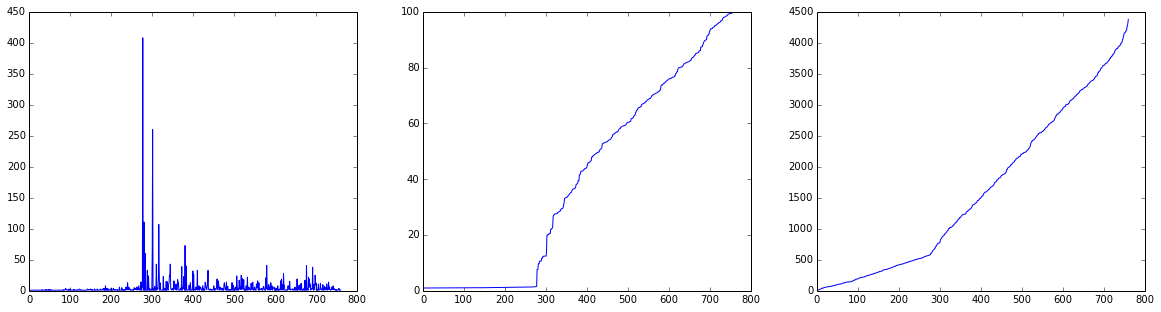

In [39]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].plot([sum(i) for i in event_list ])
ax[1].plot(conductivities)
ax[2].plot(voltages)

### ON=100 Pareto, 2

In [40]:
L_x = 32
L_y = 2 * L_x + 1
g_ON = 100
g_OFF = 1

G = gen_adj.cubic_2d_diagonal_periodic((L_y,L_x))

r, c = sparse.triu(G).nonzero()
I_threshold = sparse.lil_matrix(G.shape, dtype='float')
I_threshold[r, c] = np.random.pareto(2, size=r.size)
I_threshold = I_threshold + I_threshold.T

V_initial = I_threshold.data.min() * (L_y-1) / 1 + 1e-10

external_voltages = np.empty((L_x*L_y,))* np.nan
external_voltages[0:L_x] = V_initial
external_voltages[-L_x:] = 0

test = FuseThresholdNetwork(G, external_voltages, I_threshold, G_OFF=g_OFF, G_ON=g_ON)

test.solve_voltages('spsolve')
test.calculate_currents()

counter = 0
total_memristors = 2 * L_x * (L_y-1)


event_list = []
voltages = [test.external_voltages[0]]
conductivities = [test.conductivity()]

event_list.append(test.switching_step())
counter += sum(event_list[-1])
conductivities.append(test.conductivity())

while counter < total_memristors:
    test.update_voltage_busbar(test.new_voltage(test.external_voltages[0]))
    voltages.append(test.external_voltages[0])
    event_list.append(test.switching_step())
    counter += sum(event_list[-1])
    conductivities.append(test.conductivity())

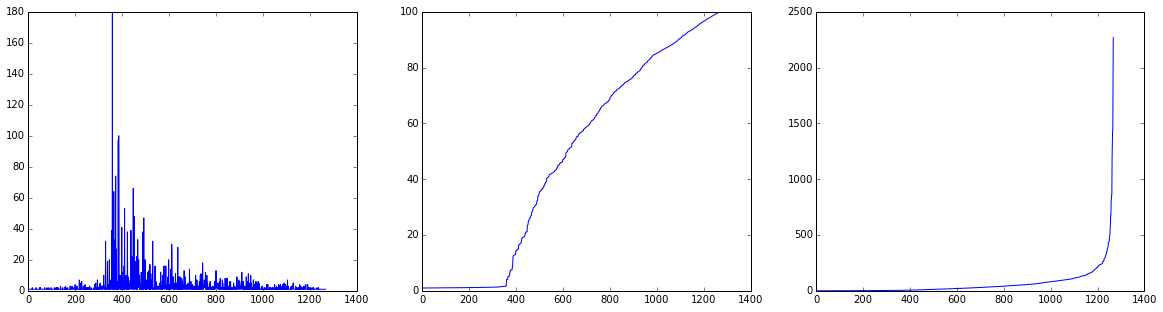

In [41]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].plot([sum(i) for i in event_list ])
ax[1].plot(conductivities)
ax[2].plot(voltages)

### ON=1000, Uniform [0, 1)

In [42]:
L_x = 32
L_y = 2 * L_x + 1
g_ON = 1000
g_OFF = 1

G = gen_adj.cubic_2d_diagonal_periodic((L_y,L_x))

r, c = sparse.triu(G).nonzero()
I_threshold = sparse.lil_matrix(G.shape, dtype='float')
I_threshold[r, c] = np.random.uniform(low=0, high=1, size=r.size)
I_threshold = I_threshold + I_threshold.T

V_initial = I_threshold.data.min() * (L_y-1) / 1 + 1e-10

external_voltages = np.empty((L_x*L_y,))* np.nan
external_voltages[0:L_x] = V_initial
external_voltages[-L_x:] = 0

test = FuseThresholdNetwork(G, external_voltages, I_threshold, G_OFF=g_OFF, G_ON=g_ON)

test.solve_voltages('spsolve')
test.calculate_currents()

counter = 0
total_memristors = 2 * L_x * (L_y-1)


event_list = []
voltages = [test.external_voltages[0]]
conductivities = [test.conductivity()]

event_list.append(test.switching_step())
counter += sum(event_list[-1])
conductivities.append(test.conductivity())

while counter < total_memristors:
    test.update_voltage_busbar(test.new_voltage(test.external_voltages[0]))
    voltages.append(test.external_voltages[0])
    event_list.append(test.switching_step())
    counter += sum(event_list[-1])
    conductivities.append(test.conductivity())

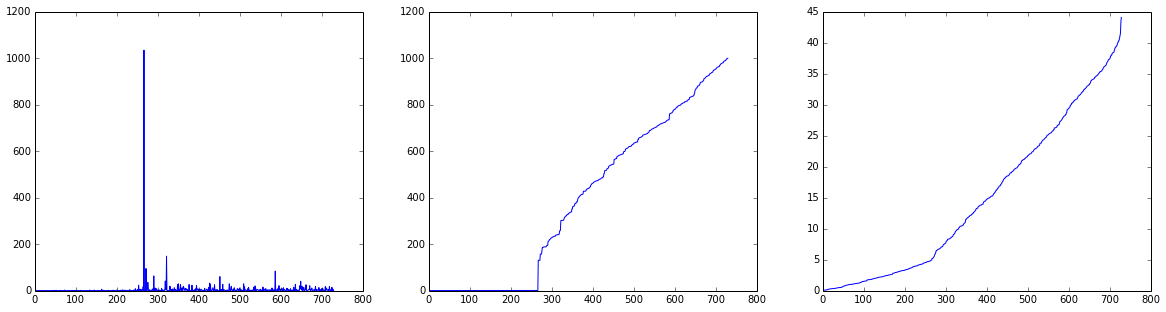

In [43]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].plot([sum(i) for i in event_list ])
ax[1].plot(conductivities)
ax[2].plot(voltages)

### ON=10 Uniform [0, 1)

In [44]:
L_x = 32
L_y = 2 * L_x + 1
g_ON = 10
g_OFF = 1

G = gen_adj.cubic_2d_diagonal_periodic((L_y,L_x))

r, c = sparse.triu(G).nonzero()
I_threshold = sparse.lil_matrix(G.shape, dtype='float')
I_threshold[r, c] = np.random.uniform(low=0, high=1, size=r.size)
I_threshold = I_threshold + I_threshold.T

V_initial = I_threshold.data.min() * (L_y-1) / 1 + 1e-10

external_voltages = np.empty((L_x*L_y,))* np.nan
external_voltages[0:L_x] = V_initial
external_voltages[-L_x:] = 0

test = FuseThresholdNetwork(G, external_voltages, I_threshold, G_OFF=g_OFF, G_ON=g_ON)

test.solve_voltages('spsolve')
test.calculate_currents()

counter = 0
total_memristors = 2 * L_x * (L_y-1)


event_list = []
voltages = [test.external_voltages[0]]
conductivities = [test.conductivity()]

event_list.append(test.switching_step())
counter += sum(event_list[-1])
conductivities.append(test.conductivity())

while counter < total_memristors:
    test.update_voltage_busbar(test.new_voltage(test.external_voltages[0]))
    voltages.append(test.external_voltages[0])
    event_list.append(test.switching_step())
    counter += sum(event_list[-1])
    conductivities.append(test.conductivity())

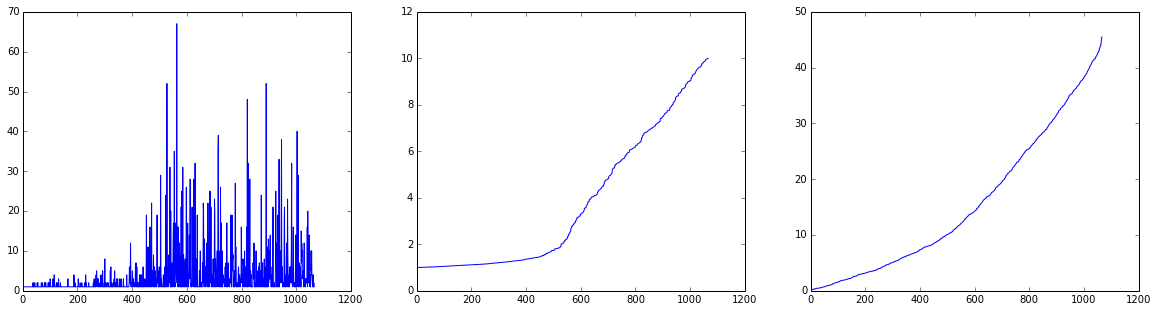

In [45]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].plot([sum(i) for i in event_list ])
ax[1].plot(conductivities)
ax[2].plot(voltages)

### ON=10 Uniform [1, 2)

In [80]:
L_x = 32
L_y = 2 * L_x + 1
g_ON = 1.75
g_OFF = 1

G = gen_adj.cubic_2d_diagonal_periodic((L_y,L_x))

r, c = sparse.triu(G).nonzero()
I_threshold = sparse.lil_matrix(G.shape, dtype='float')
I_threshold[r, c] = np.random.uniform(low=1, high=2, size=r.size)
I_threshold = I_threshold + I_threshold.T

V_initial = I_threshold.data.min() * (L_y-1) / 1 + 1e-10

external_voltages = np.empty((L_x*L_y,))* np.nan
external_voltages[0:L_x] = V_initial
external_voltages[-L_x:] = 0

test = FuseThresholdNetwork(G, external_voltages, I_threshold, G_OFF=g_OFF, G_ON=g_ON)

test.solve_voltages('spsolve')
test.calculate_currents()

counter = 0
total_memristors = 2 * L_x * (L_y-1)


event_list = []
voltages = [test.external_voltages[0]]
conductivities = [test.conductivity()]

event_list.append(test.switching_step())
counter += sum(event_list[-1])
conductivities.append(test.conductivity())

while counter < total_memristors:
    test.update_voltage_busbar(test.new_voltage(test.external_voltages[0]))
    voltages.append(test.external_voltages[0])
    event_list.append(test.switching_step())
    counter += sum(event_list[-1])
    conductivities.append(test.conductivity())

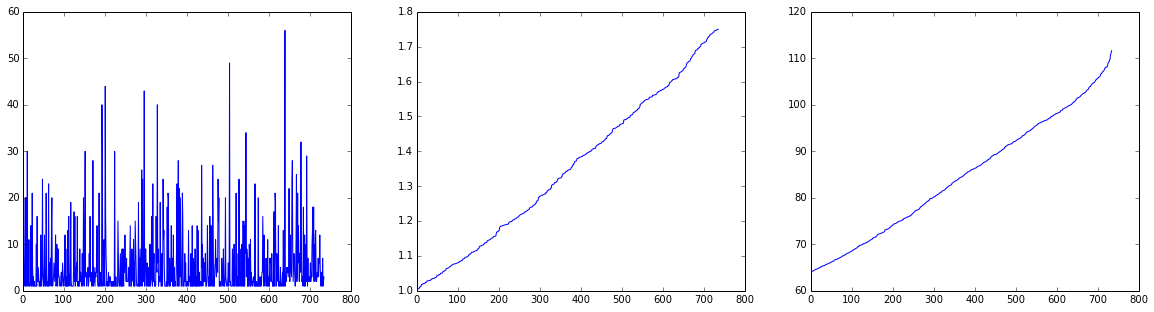

In [81]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].plot([sum(i) for i in event_list ])
ax[1].plot(conductivities)
ax[2].plot(voltages)

### ON=10, Weibull lambda=1 k=5

In [82]:
L_x = 32
L_y = 2 * L_x + 1
g_ON = 10
g_OFF = 1

G = gen_adj.cubic_2d_diagonal_periodic((L_y,L_x))

r, c = sparse.triu(G).nonzero()
I_threshold = sparse.lil_matrix(G.shape, dtype='float')
I_threshold[r, c] = np.random.weibull(5, size=r.size)
I_threshold = I_threshold + I_threshold.T

V_initial = I_threshold.data.min() * (L_y-1) / 1 + 1e-10

external_voltages = np.empty((L_x*L_y,))* np.nan
external_voltages[0:L_x] = V_initial
external_voltages[-L_x:] = 0

test = FuseThresholdNetwork(G, external_voltages, I_threshold, G_OFF=g_OFF, G_ON=g_ON)

test.solve_voltages('spsolve')
test.calculate_currents()

counter = 0
total_memristors = 2 * L_x * (L_y-1)


event_list = []
voltages = [test.external_voltages[0]]
conductivities = [test.conductivity()]

event_list.append(test.switching_step())
counter += sum(event_list[-1])
conductivities.append(test.conductivity())

while counter < total_memristors:
    test.update_voltage_busbar(test.new_voltage(test.external_voltages[0]))
    voltages.append(test.external_voltages[0])
    event_list.append(test.switching_step())
    counter += sum(event_list[-1])
    conductivities.append(test.conductivity())

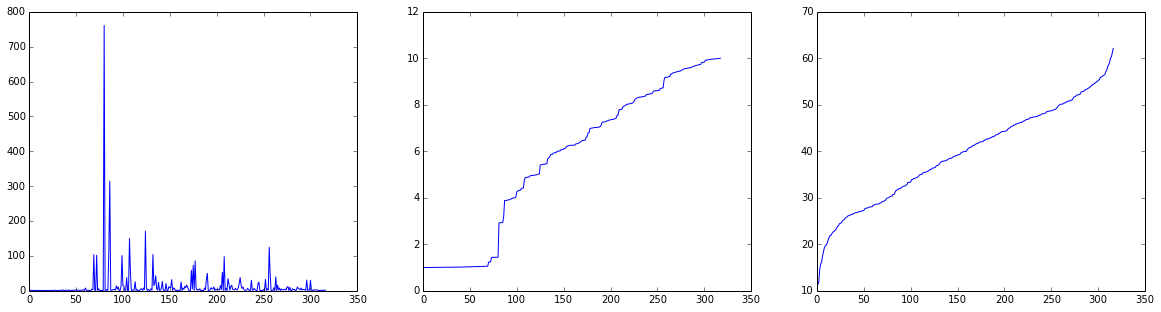

In [83]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].plot([sum(i) for i in event_list ])
ax[1].plot(conductivities)
ax[2].plot(voltages)

### Displaying the Networks

In [17]:
L_x = 12
L_y = 2 * L_x + 1
g_ON = 100
g_OFF = 1

G = gen_adj.cubic_2d_diagonal_periodic((L_y,L_x))

r, c = sparse.triu(G).nonzero()
I_threshold = sparse.lil_matrix(G.shape, dtype='float')
I_threshold[r, c] = np.random.uniform(low=0, high=1, size=r.size)
I_threshold = I_threshold + I_threshold.T

V_initial = I_threshold.data.min() * (L_y-1) / 1 + 1e-10

external_voltages = np.empty((L_x*L_y,))* np.nan
external_voltages[0:L_x] = V_initial
external_voltages[-L_x:] = 0

test = FuseThresholdNetwork(G, external_voltages, I_threshold, G_OFF=g_OFF, G_ON=g_ON)

fig, ax = plt.subplots(3,4, figsize=(16, 12))

test.solve_voltages('spsolve')
test.calculate_currents()

test.display_diag_grid(ax[0,0], (L_y, L_x), 'conductance')
ax[0,0].set_axis_off()

counter = 0

total_memristors = 2 * L_x * (L_y-1)


event_list = []
voltages = [test.external_voltages[0]]
conductivities = [test.conductivity()]

event_list.append(test.switching_step())
counter += sum(event_list[-1])
conductivities.append(test.conductivity())
step = 1

while counter < total_memristors:
    test.update_voltage_busbar(test.new_voltage(test.external_voltages[0]))
    voltages.append(test.external_voltages[0])
    event_list.append(test.switching_step())
    counter += sum(event_list[-1])
    conductivities.append(test.conductivity())
    step +=1
    if step % 7 == 0:
        if step // 7 < 12:
            test.display_diag_grid(ax[step // 7 // 4, (step // 7) % 4], (L_y, L_x), 'conductance')
            ax[step // 7 // 4, (step // 7) % 4].set_axis_off()
    
plt.tight_layout()
fig.savefig('Inside_a_network.png')

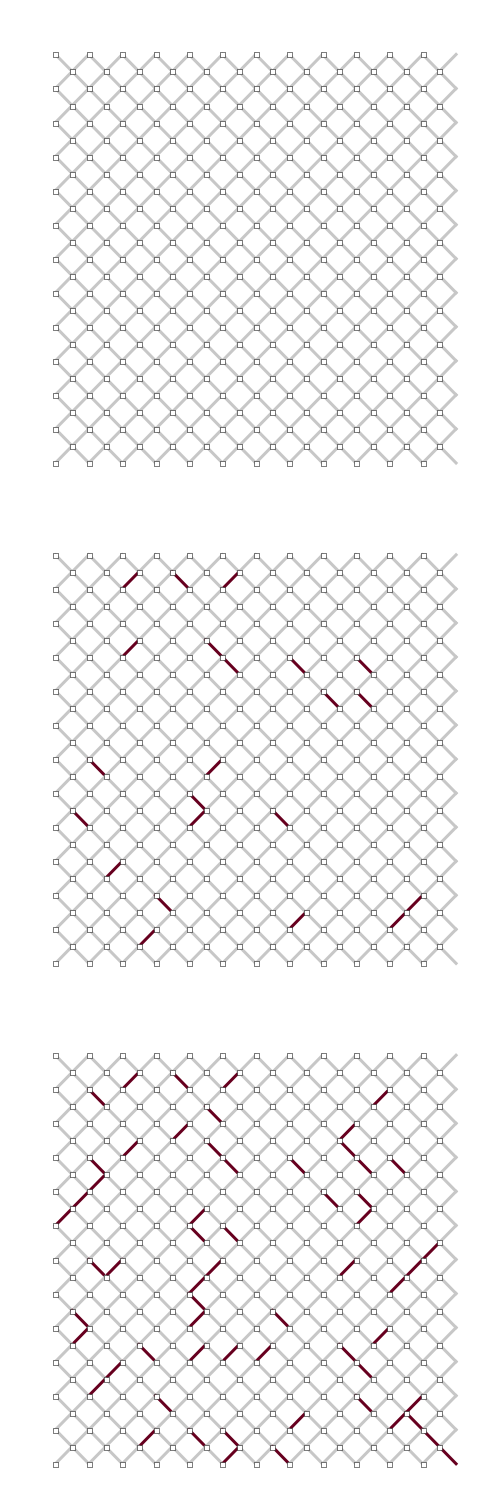

In [7]:
L_x = 12
L_y = 2 * L_x + 1
g_ON = 100
g_OFF = 1

G = gen_adj.cubic_2d_diagonal_periodic((L_y,L_x))

r, c = sparse.triu(G).nonzero()
I_threshold = sparse.lil_matrix(G.shape, dtype='float')
I_threshold[r, c] = np.random.uniform(low=0, high=1, size=r.size)
I_threshold = I_threshold + I_threshold.T

V_initial = I_threshold.data.min() * (L_y-1) / 1 + 1e-10

external_voltages = np.empty((L_x*L_y,))* np.nan
external_voltages[0:L_x] = V_initial
external_voltages[-L_x:] = 0

test = FuseThresholdNetwork(G, external_voltages, I_threshold, G_OFF=g_OFF, G_ON=g_ON)

fig, ax = plt.subplots(3, 1, figsize=(7, 21))

test.solve_voltages('spsolve')
test.calculate_currents()

test.display_diag_grid(ax[0], (L_y, L_x), 'conductance')
ax[0].set_axis_off()

counter = 0

total_memristors = 2 * L_x * (L_y-1)


event_list = []
voltages = [test.external_voltages[0]]
conductivities = [test.conductivity()]

event_list.append(test.switching_step())
counter += sum(event_list[-1])
conductivities.append(test.conductivity())
step = 1

while counter < total_memristors:
    test.update_voltage_busbar(test.new_voltage(test.external_voltages[0]))
    voltages.append(test.external_voltages[0])
    event_list.append(test.switching_step())
    counter += sum(event_list[-1])
    conductivities.append(test.conductivity())
    step +=1
    if step % 20 == 0:
        if step // 20 < 3:
            test.display_diag_grid(ax[step // 20], (L_y, L_x), 'conductance')
            ax[step // 20].set_axis_off()
    
plt.tight_layout()


fig.savefig('Inside_a_network.png')

In [13]:
L_x = 16
L_y = 2 * L_x + 1
g_ON = 1000
g_OFF = 1

G = gen_adj.cubic_2d_diagonal_periodic((L_y,L_x))

r, c = sparse.triu(G).nonzero()
I_threshold = sparse.lil_matrix(G.shape, dtype='float')
I_threshold[r, c] = np.random.uniform(low=0, high=1, size=r.size)
I_threshold = I_threshold + I_threshold.T

V_initial = I_threshold.data.min() * (L_y-1) / 1 + 1e-10

external_voltages = np.empty((L_x*L_y,))* np.nan
external_voltages[0:L_x] = V_initial
external_voltages[-L_x:] = 0

test = FuseThresholdNetwork(G, external_voltages, I_threshold, G_OFF=g_OFF, G_ON=g_ON)

fig, ax = plt.subplots(figsize=(10, 10))

test.solve_voltages('spsolve')
test.calculate_currents()

test.display_diag_grid(ax, (L_y, L_x), 'conductance')
ax.set_axis_off()
step = 0
fig.savefig('movie_imgs/switching_net_'+str(step)+'.png')
ax.cla()
counter = 0

total_memristors = 2 * L_x * (L_y-1)


event_list = []
voltages = [test.external_voltages[0]]
conductivities = [test.conductivity()]

event_list.append(test.switching_step())
counter += sum(event_list[-1])
conductivities.append(test.conductivity())
step = 1
test.display_diag_grid(ax, (L_y, L_x), 'conductance')
ax.set_axis_off()
fig.savefig('movie_imgs/switching_net_'+str(step)+'.png')
ax.cla()

while counter < total_memristors:
    test.update_voltage_busbar(test.new_voltage(test.external_voltages[0]))
    voltages.append(test.external_voltages[0])
    event_list.append(test.switching_step())
    counter += sum(event_list[-1])
    conductivities.append(test.conductivity())
    step +=1
    test.display_diag_grid(ax, (L_y, L_x), 'conductance')
    ax.set_axis_off()
    fig.savefig('movie_imgs/switching_net_'+str(step)+'.png')
    ax.cla()




In [14]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].plot([sum(i) for i in event_list ])
ax[1].plot(conductivities)
ax[2].plot(voltages)

In [16]:
from matplotlib import animation  
import matplotlib.image as mgimg


#set up the figure
fig = plt.figure(figsize=(10,10))
ax = plt.gca()
ax.set_axis_off()

#initialization of animation, plot array of zeros 
def init():
    imobj.set_data(np.zeros((100, 100)))

    return  imobj,

def animate(i):
    ## Read in picture
    fname = "movie_imgs/switching_net_%d.png" % i 

    ## here I use [-1::-1], to invert the array
    # IOtherwise it plots up-side down
    img = mgimg.imread(fname)[-1::-1]
    imobj.set_data(img)

    return  imobj,


## create an AxesImage object
imobj = ax.imshow( np.zeros((100, 100)), origin='lower', alpha=1.0, zorder=1, aspect=1 )


anim = animation.FuncAnimation(fig, animate, init_func=init, repeat = True,
                               frames=range(0,227), interval=200, blit=True, repeat_delay=1000)

anim.save('Advancement_presentation/switching_anim_L16ON1000.mp4', fps=5, extra_args=['-vcodec', 'libx264'])

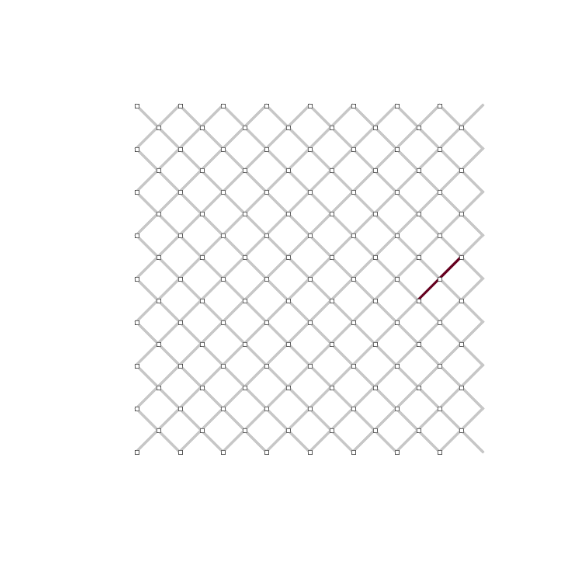

In [19]:
fig = plt.figure(figsize=(10,10))
ax = plt.gca()
ax.set_axis_off()
i=2
fname = "movie_imgs/switching_net_%d.png" % i
img = mgimg.imread(fname)[-1::-1]

imobj = ax.imshow(np.zeros((100,100)), origin='lower', alpha=1.0, zorder=1, aspect=1)
imobj.set_data(img)




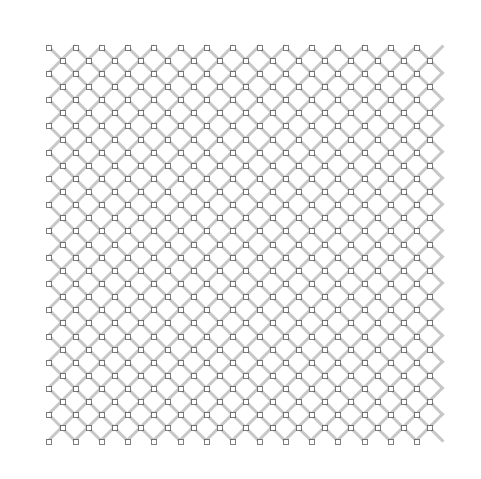

In [11]:
L_x = 15
L_y = 2 * L_x + 1
g_ON = 100
g_OFF = 1

G = gen_adj.cubic_2d_diagonal_periodic((L_y,L_x))

r, c = sparse.triu(G).nonzero()
I_threshold = sparse.lil_matrix(G.shape, dtype='float')
I_threshold[r, c] = np.random.uniform(low=0, high=1, size=r.size)
I_threshold = I_threshold + I_threshold.T

V_initial = I_threshold.data.min() * (L_y-1) / 1 + 1e-10

external_voltages = np.empty((L_x*L_y,))* np.nan
external_voltages[0:L_x] = V_initial
external_voltages[-L_x:] = 0

test = FuseThresholdNetwork(G, external_voltages, I_threshold, G_OFF=g_OFF, G_ON=g_ON)

test.solve_voltages('spsolve')
test.calculate_currents()


fig, ax = plt.subplots(figsize=(8,8))

test.display_diag_grid(ax, (L_y, L_x), 'conductance')

ax.set_axis_off()
fig.savefig(filename='Advancement_presentation/diag_network.png')

(5, 5)

## Data

### ON=2

In [22]:
run_ON2 = np.load('fuse_threshold_data/FuseThreshold_L128_ON2run1.npz')
av_ON2 = [sum(i) for i in run_ON2['avalanches']]
cond_ON2 = run_ON2['conductivities']
volt_ON2 = run_ON2['voltages']

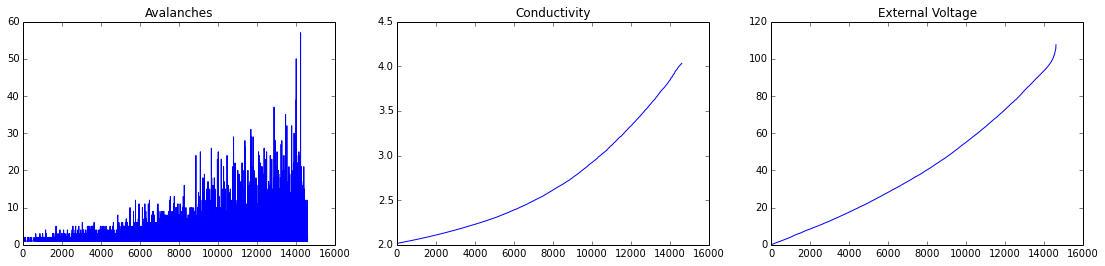

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(19, 4))

ax[0].plot(av_ON2)
ax[0].set_title("Avalanches")
ax[1].plot(cond_ON2)
ax[1].set_title("Conductivity")
ax[2].plot(volt_ON2)
ax[2].set_title("External Voltage")
fig.savefig('ON2_run.png')

### ON=10

In [7]:
run_ON10 = np.load('fuse_threshold_data/FuseThreshold_L128_ON10run1.npz')
av_ON10 = [sum(i) for i in run_ON10['avalanches']]
cond_ON10 = run_ON10['conductivities']
volt_ON10 = run_ON10['voltages']

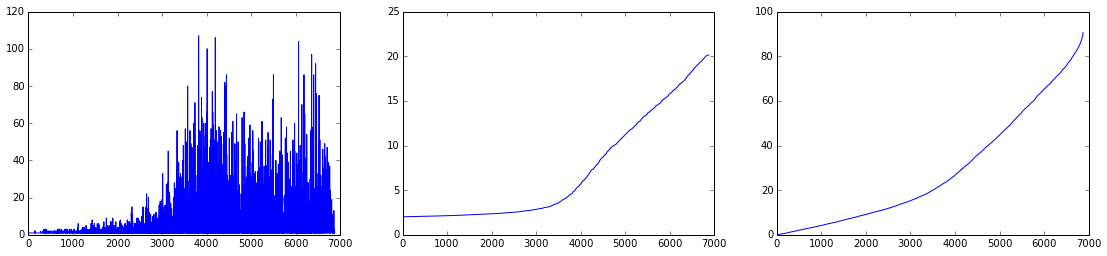

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(19, 4))

ax[0].plot(av_ON10)
ax[1].plot(cond_ON10)
ax[2].plot(volt_ON10)

### ON=100

In [28]:
run_ON100 = np.load('fuse_threshold_data/FuseThreshold_L128_ON100run1.npz')
av_ON100 = [sum(i) for i in run_ON100['avalanches']]
cond_ON100 = run_ON100['conductivities']
volt_ON100 = run_ON100['voltages']

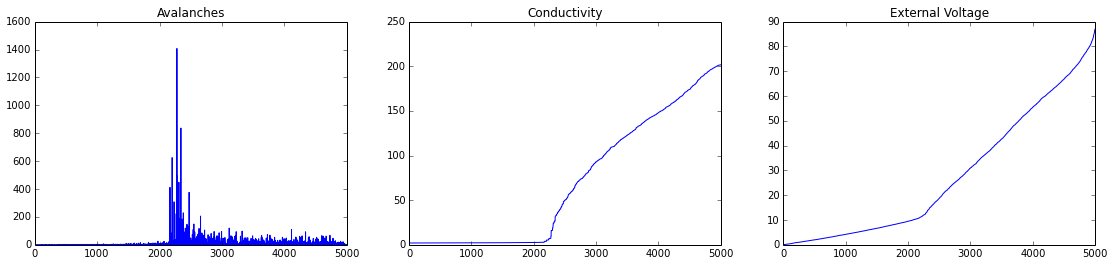

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(19, 4))

ax[0].plot(av_ON100)
ax[0].set_title("Avalanches")
ax[1].plot(cond_ON100)
ax[1].set_title("Conductivity")
ax[2].plot(volt_ON100)
ax[2].set_title("External Voltage")
fig.savefig('ON100_run.png')

### ON=1000

In [32]:
run_ON1000 = np.load('fuse_threshold_data/FuseThreshold_L128_ON1000run1.npz')
av_ON1000 = [sum(i) for i in run_ON1000['avalanches']]
cond_ON1000 = run_ON1000['conductivities']
volt_ON1000 = run_ON1000['voltages']

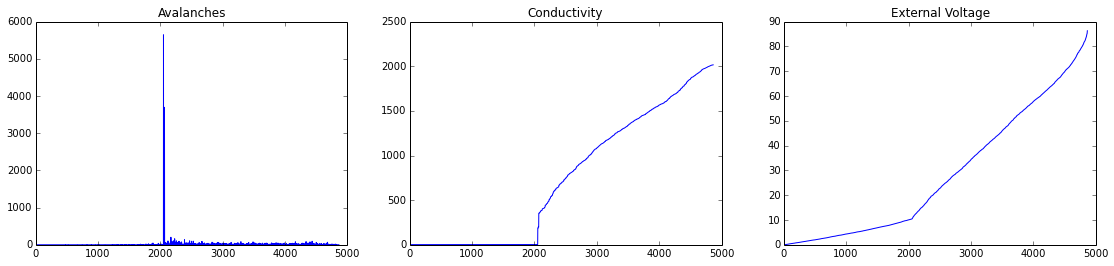

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(19, 4))

ax[0].plot(av_ON1000)
ax[0].set_title("Avalanches")
ax[1].plot(cond_ON1000)
ax[1].set_title("Conductivity")
ax[2].plot(volt_ON1000)
ax[2].set_title("External Voltage")
fig.savefig('ON1000_run.png')

In [13]:
run_ON1000000 = np.load('fuse_threshold_data/FuseThreshold_L128_ON1000000run1.npz')
av_ON1000000 = [sum(i) for i in run_ON1000000['avalanches']]
cond_ON1000000 = run_ON1000000['conductivities']
volt_ON1000000 = run_ON1000000['voltages']

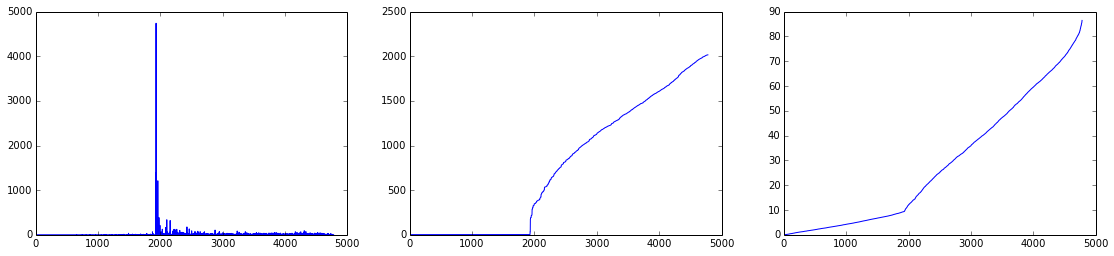

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(19, 4))

ax[0].plot(av_ON1000)
ax[1].plot(cond_ON1000)
ax[2].plot(volt_ON1000)

### Bipolar Switching 

### Switching from OFF to ON

In [ ]:
I_threshold = sparse.lil_matrix(G.shape, dtype='float')
I_threshold[r, c] = np.random.uniform(low=0, high=1, size=r.size)
I_threshold = I_threshold + I_threshold.T

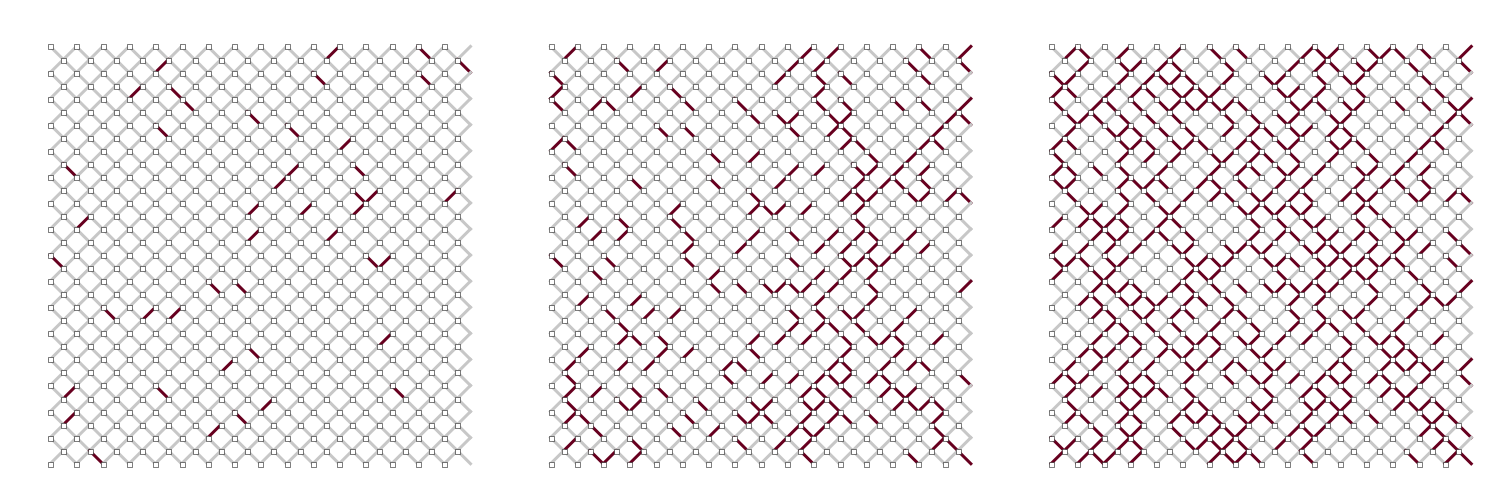

In [66]:
L_x = 16
L_y = 2 * L_x + 1
g_ON = 100
g_OFF = 1

fig, ax = plt.subplots(1, 3, figsize=(21, 7))

G = gen_adj.cubic_2d_diagonal_periodic((L_y,L_x))

r, c = sparse.triu(G).nonzero()
#I_threshold = sparse.lil_matrix(G.shape, dtype='float')
#I_threshold[r, c] = np.random.uniform(low=0, high=1, size=r.size)
#I_threshold = I_threshold + I_threshold.T

V_initial = I_threshold.data.min() * (L_y-1) / g_OFF + 1e-10

external_voltages = np.empty((L_x*L_y,))* np.nan
external_voltages[0:L_x] = V_initial
external_voltages[-L_x:] = 0

test = FuseThresholdNetwork(G, external_voltages, I_threshold=I_threshold, G_OFF=g_OFF, G_ON=g_ON)

test.solve_voltages('spsolve')
test.calculate_currents()

counter = 0
total_memristors = 2 * L_x * (L_y-1)


event_list = []
voltages = [test.external_voltages[0]]
conductivities = [test.conductivity()]

event_list.append(test.switching_step())
counter += sum(event_list[-1])
conductivities.append(test.conductivity())
step=1
while counter < total_memristors:
    test.update_voltage_busbar(test.new_voltage(test.external_voltages[0]))
    voltages.append(test.external_voltages[0])
    event_list.append(test.switching_step())
    counter += sum(event_list[-1])
    conductivities.append(test.conductivity())
    step += 1
    if step == 40:
        test.display_diag_grid(ax[0], (L_y, L_x), 'conductance')
        ax[0].set_axis_off()
    if step == 83:
        test.display_diag_grid(ax[1], (L_y, L_x), 'conductance')
        ax[1].set_axis_off()
    if step == 100:
        test.display_diag_grid(ax[2], (L_y, L_x), 'conductance')
        ax[2].set_axis_off()
        
plt.tight_layout()


voltages_OFF2ONlist = []
conductivities_OFF2ONlist = []
for n, v in enumerate(voltages):
    voltages_OFF2ONlist.extend([v, v])
    conductivities_OFF2ONlist.extend([conductivities[n], conductivities[n+1]])
    
voltages_OFF2ON = np.array(voltages_OFF2ONlist)
conductivities_OFF2ON = np.array(conductivities_OFF2ONlist)

fig.savefig('Inside_network_ON100.png')

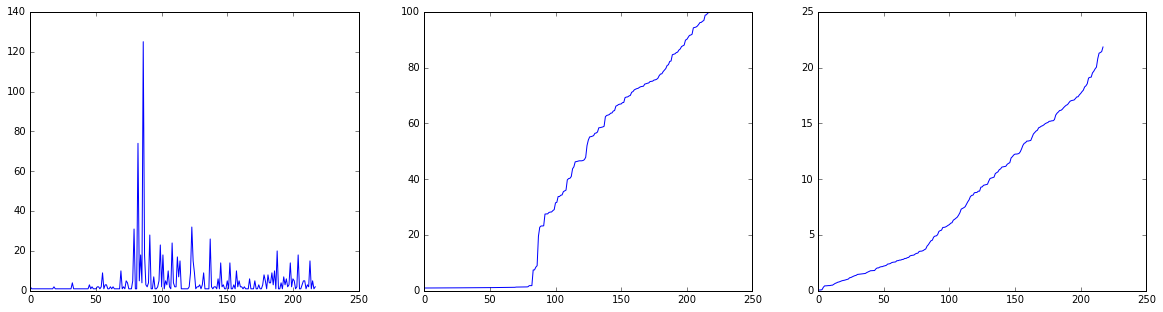

In [67]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].plot([sum(i) for i in event_list ])
ax[1].plot(conductivities)
ax[2].plot(voltages)

### Switching from ON to OFF

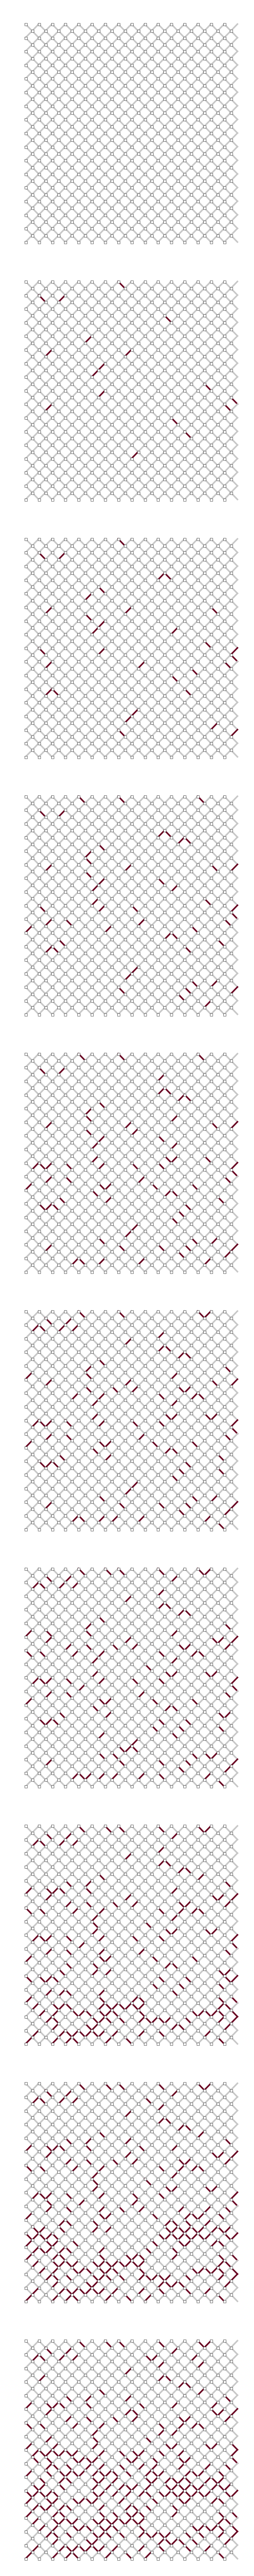

In [13]:
L_x = 16
L_y = 2 * L_x + 1
g_ON = 1
g_OFF = 1000

fig, ax = plt.subplots(10, 1, figsize=(7, 70))

G = gen_adj.cubic_2d_diagonal_periodic((L_y,L_x)) * g_OFF

r, c = sparse.triu(G).nonzero()
I_threshold = sparse.lil_matrix(G.shape, dtype='float')
I_threshold[r, c] = np.random.uniform(low=0, high=1., size=r.size)

I_threshold = I_threshold + I_threshold.T

V_initial = I_threshold.data.min() * (L_y-1) / g_OFF + 1e-10

external_voltages = np.empty((L_x*L_y,))* np.nan
external_voltages[0:L_x] = V_initial
external_voltages[-L_x:] = 0

test = FuseThresholdNetwork(G, external_voltages, I_threshold=I_threshold, G_OFF=g_OFF, G_ON=g_ON)

test.solve_voltages('spsolve')
test.calculate_currents()

test.display_diag_grid(ax[0], (L_y, L_x), 'conductance')
ax[0].set_axis_off()

counter = 0
total_memristors = 2 * L_x * (L_y-1)


event_list = []
voltages = [test.external_voltages[0]]
conductivities = [test.conductivity()]

event_list.append(test.switching_step())
counter += sum(event_list[-1])
conductivities.append(test.conductivity())
step = 1
step_idx = 15

while counter < total_memristors:
    test.update_voltage_busbar(test.new_voltage(test.external_voltages[0]))
    voltages.append(test.external_voltages[0])
    event_list.append(test.switching_step())
    counter += sum(event_list[-1])
    conductivities.append(test.conductivity())
    step += 1
    if step % step_idx == 0:
        if step // step_idx < 10:
            test.display_diag_grid(ax[step // step_idx], (L_y, L_x), 'conductance')
            ax[step // step_idx].set_axis_off()
    
plt.tight_layout()


voltages_ON2OFFlist = []
conductivities_ON2OFFlist = []
for n, v in enumerate(voltages):
    voltages_ON2OFFlist.extend([v, v])
    conductivities_ON2OFFlist.extend([conductivities[n], conductivities[n+1]])
    
voltages_ON2OFF = np.array(voltages_ON2OFFlist)
conductivities_ON2OFF = np.array(conductivities_ON2OFFlist)

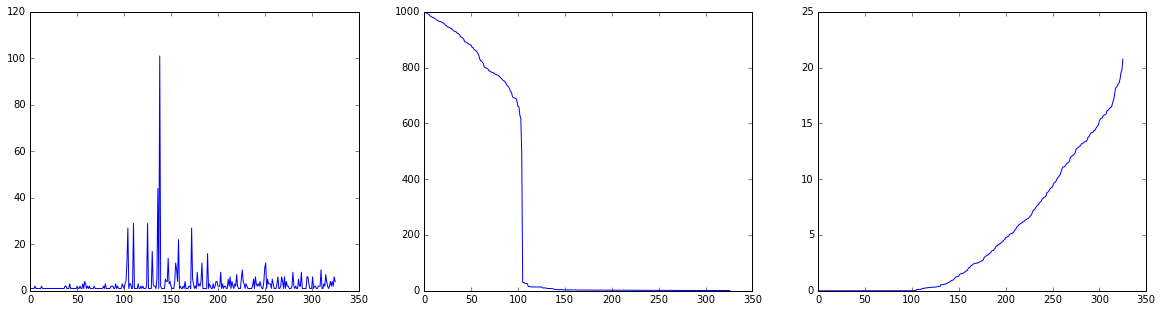

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].plot([sum(i) for i in event_list ])
ax[1].plot(conductivities)
ax[2].plot(voltages)

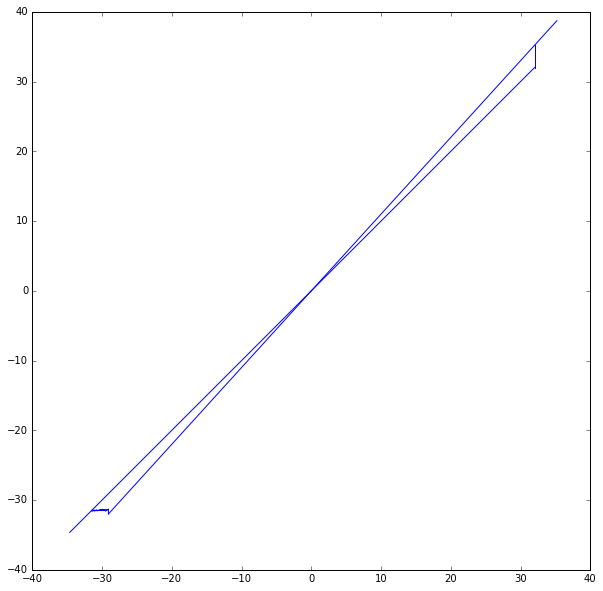

In [23]:
fig, ax = plt.subplots(figsize=(10,10))
g_ON = 1.1
g_OFF = 1

G_ON = g_ON / ( L_y - 1) * 2 * L_x

G_OFF = g_OFF / ( L_y - 1) * 2 * L_x

ax.plot([0, voltages_OFF2ON[0]], [0, conductivities_OFF2ON[0]*voltages_OFF2ON[0]])
ax.plot(voltages_OFF2ON, conductivities_OFF2ON*voltages_OFF2ON, c='b')
ax.plot([0, 1.1*voltages_OFF2ON[-1]],  [0, G_ON * 1.1*voltages_OFF2ON[-1]], c='b')
ax.plot([0, -1*voltages_ON2OFF[0]], [0, -1*conductivities_ON2OFF[0]*voltages_ON2OFF[0]], c='b')
ax.plot(-1*voltages_ON2OFF, -1*conductivities_ON2OFF*voltages_ON2OFF, c='b')
ax.plot([0, -1.1*voltages_ON2OFF[-1]],  [0, G_OFF *-1.1*voltages_ON2OFF[-1]], c='b')
#ax.set_ylim(-75, 0)

0.32033364731781977

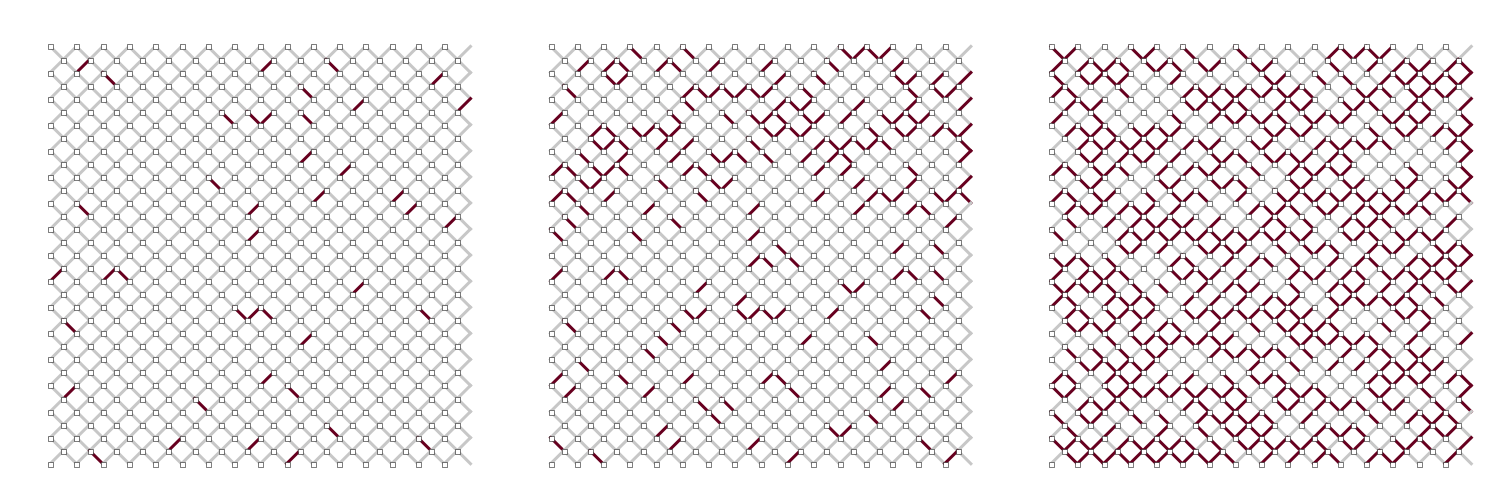

In [90]:
L_x = 16
L_y = 2 * L_x + 1
g_ON = 1
g_OFF = 1000

fig, ax = plt.subplots(1, 3, figsize=(21, 7))

G = gen_adj.cubic_2d_diagonal_periodic((L_y,L_x)) * g_OFF

r, c = sparse.triu(G).nonzero()
I_threshold = sparse.lil_matrix(G.shape, dtype='float')
I_threshold[r, c] = np.random.uniform(low=0, high=1., size=r.size)

I_threshold = I_threshold + I_threshold.T

V_initial = I_threshold.data.min() * (L_y-1) / g_OFF + 1e-10

external_voltages = np.empty((L_x*L_y,))* np.nan
external_voltages[0:L_x] = V_initial
external_voltages[-L_x:] = 0

test = FuseThresholdNetwork(G, external_voltages, I_threshold=I_threshold, G_OFF=g_OFF, G_ON=g_ON)

test.solve_voltages('spsolve')
test.calculate_currents()

counter = 0
total_memristors = 2 * L_x * (L_y-1)


event_list = []
voltages = [test.external_voltages[0]]
conductivities = [test.conductivity()]

event_list.append(test.switching_step())
counter += sum(event_list[-1])
conductivities.append(test.conductivity())
step = 1


while counter < total_memristors:
    test.update_voltage_busbar(test.new_voltage(test.external_voltages[0]))
    voltages.append(test.external_voltages[0])
    event_list.append(test.switching_step())
    counter += sum(event_list[-1])
    conductivities.append(test.conductivity())
    step += 1
    if step == 40:
        test.display_diag_grid(ax[0], (L_y, L_x), 'conductance')
        ax[0].set_axis_off()
    if step == 110:
        test.display_diag_grid(ax[1], (L_y, L_x), 'conductance')
        ax[1].set_axis_off()
    if step == 180:
        test.display_diag_grid(ax[2], (L_y, L_x), 'conductance')
        ax[2].set_axis_off()
        
plt.tight_layout()


voltages_ON2OFFlist = []
conductivities_ON2OFFlist = []
for n, v in enumerate(voltages):
    voltages_ON2OFFlist.extend([v, v])
    conductivities_ON2OFFlist.extend([conductivities[n], conductivities[n+1]])
    
voltages_ON2OFF = np.array(voltages_ON2OFFlist)
conductivities_ON2OFF = np.array(conductivities_ON2OFFlist)
fig.savefig('Inside_network_ON1000_ON2OFF.png')

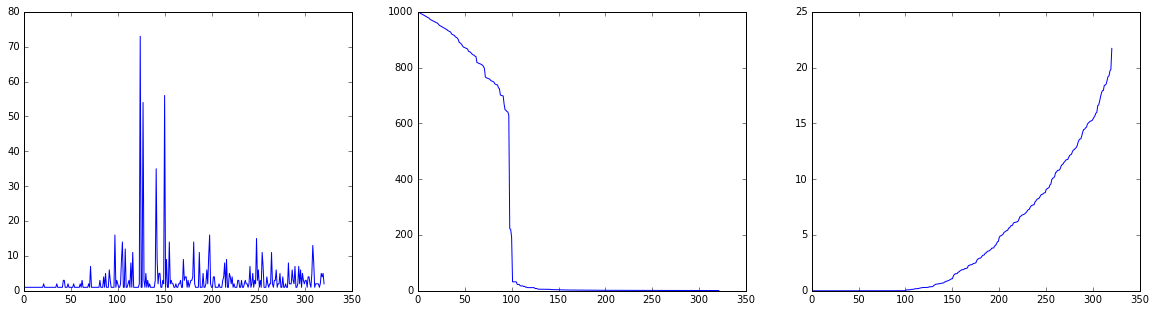

In [91]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].plot([sum(i) for i in event_list ])
ax[1].plot(conductivities)
ax[2].plot(voltages)